## Objective

    OK - Open each image, split it in 4x4. 
    OK - Use find_voids to count number of voids in it.
    WIP- Colorize grains (1)
    4 - If voids>0 
            Recontruct boundaries
            Colorize after reconstruction (2)
        Else
            Copy (1)

    5 - Save (1) and (2) as train dataset



### Open images and split in 16


In [68]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill
import cv2
import math
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

import find_voids as fv


In [4]:

folder = "../data/"
file = "1_001"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [8]:

origin = [0, 0]
refvec = [0, 1]

def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
   
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

In [5]:

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})

df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')



df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})

df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')



df_grains = df_left.join(df_right)

df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

In [69]:

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

flooded_grains = np.zeros([height, width, 3])
overflood = np.sum(flooded_grains==0) * 0.8
print(overflood)
over = []
out = []

for grain in df_grains.index:
#        grain = 1512
        One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
        grain_info = df_grains_norm.loc[grain,:]
        np_img = np.zeros([height, width, 3])

        #  width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
        #  height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

        x_center = math.ceil(One_grain[['x_start','x_end']].mean().mean())
        y_center = math.ceil(One_grain[['y_start','y_end']].mean().mean())


       # if(x_center < 200 and y_center < 200): 
        phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
        #    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)

        for idx, row in One_grain.iterrows():

            rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
            np_img[cc,rr] = (1,1,1)

        mask = flood(np_img, (y_center, x_center,0))
        #        print(str(grain) + " len "+ str(np.count_nonzero(mask)))
        #        print(str(grain) + " len 0 "+ str(np.sum(mask==1)))
        np_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]

        if (np.sum(mask==1)<overflood):
            flooded_grains[mask[:,:,1] !=0] = [phi1,Phi,phi2]
            flooded_grains[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
            #flood_grains = cv2.bitwise_or(np_img,flood_grains)
            
          #  print("ok")



        else:
            over.append(grain)
            One_grain = One_grain[One_grain["length"]>2]

            start = pd.DataFrame(columns=["x","y"])
            end = pd.DataFrame(columns=["x","y"])
            start[["x","y"]] = One_grain[['x_start','y_start']]
            end[["x","y"]] = One_grain[['x_end','y_end']]
            points = pd.concat([start,end])

            p = points.drop_duplicates()
            p1 = p.to_numpy()

            origin = [x_center,y_center]
            
            sort = sorted(p1, key=clockwiseangle_and_distance)
            a = []
            for b in sort:
                a.append(tuple((int(b[0]),int(b[1]))))

            cv2.polylines(np_img, np.array([a]), True, (phi1,Phi,phi2), 2)


            mask = flood(np_img, (y_center, x_center,0))
            if(np.sum(mask==1)<overflood):
#                np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
#                 cv2.imshow('f',flood_grains)
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()
                
                flooded_grains[mask[:,:,1] !=0] = [phi1,Phi,phi2]
                flooded_grains[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
            else:
                out.append(grain)
            #cv2.putText(flooded_grains, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.2, color=(255,255,255), thickness=1)
        
N = width//4
M = height//4

tiles = [flooded_grains[x:x+M,y:y+N] for x in range(0,flooded_grains.shape[0],M) for y in range(0,flooded_grains.shape[1],N)]


2515200.0


In [31]:
cv2.imshow('Image',flooded_grains)
cv2.waitKey(0)
cv2.destroyAllWindows()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


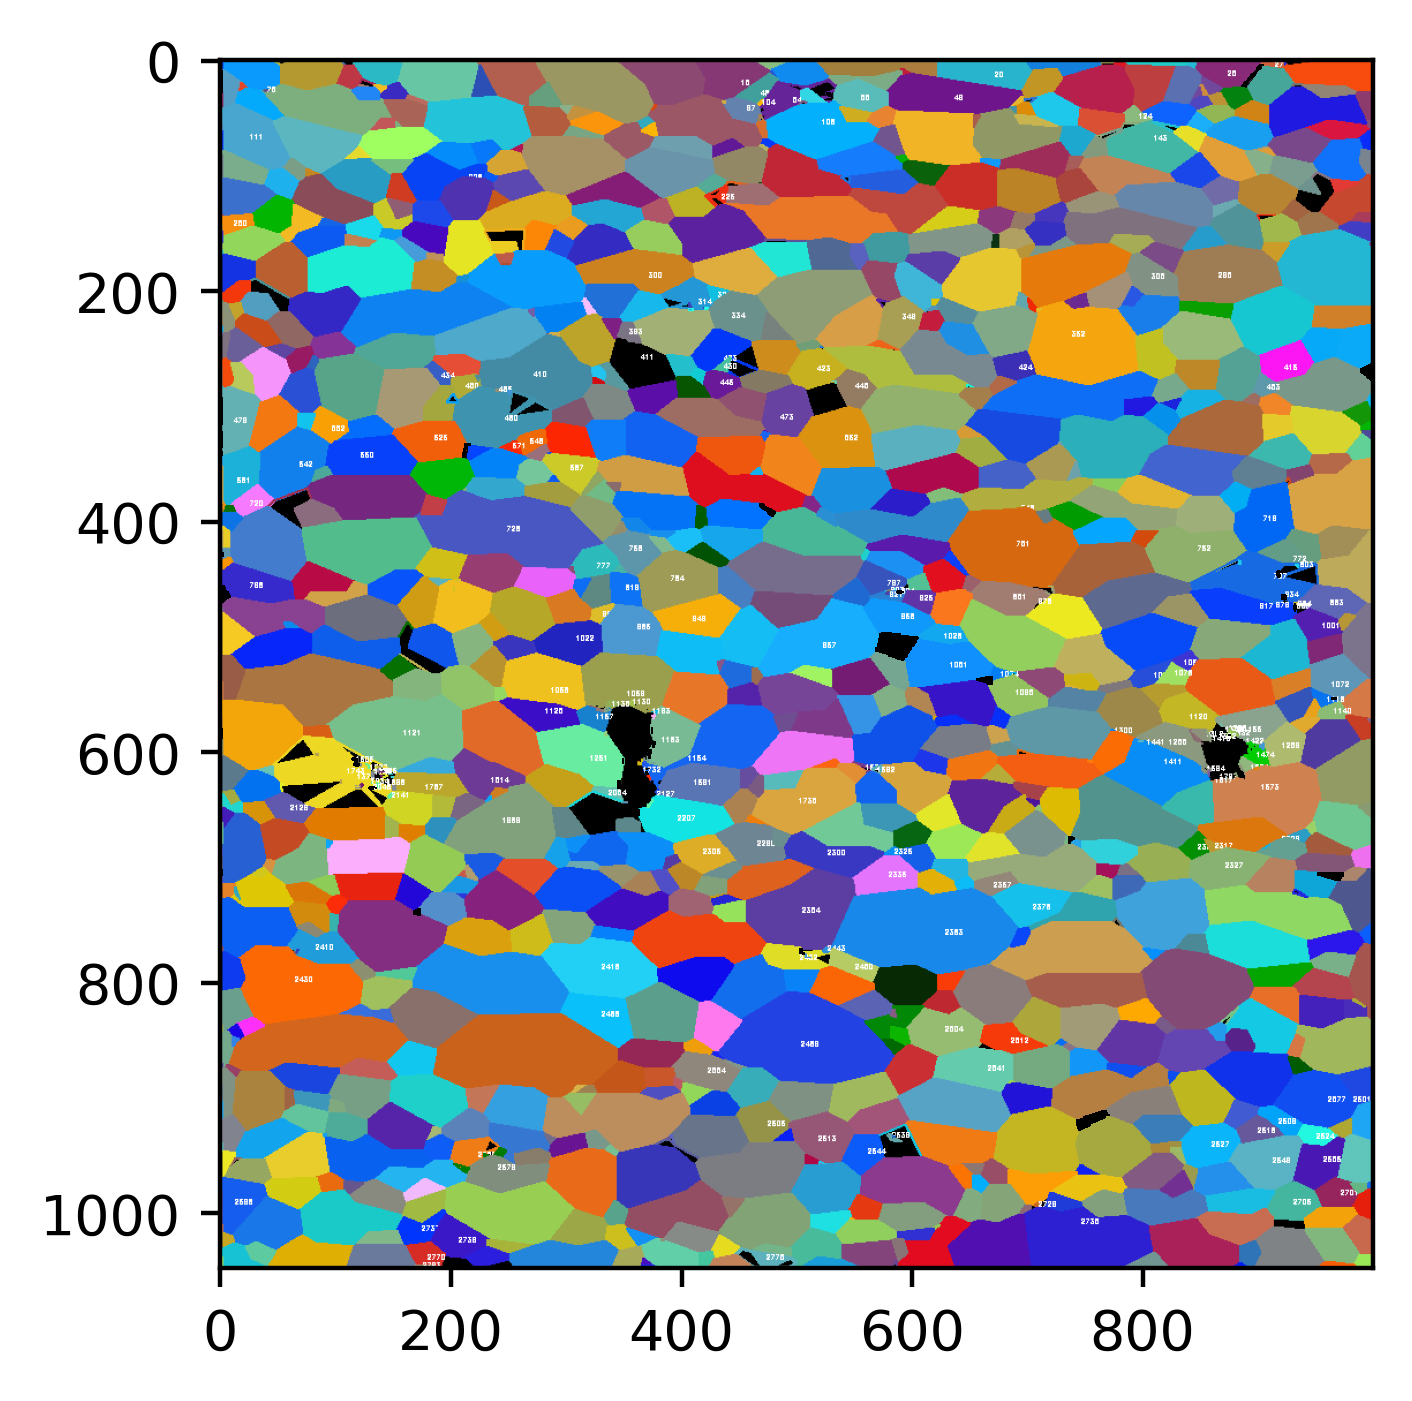

In [70]:
plt.imshow(flooded_grains)

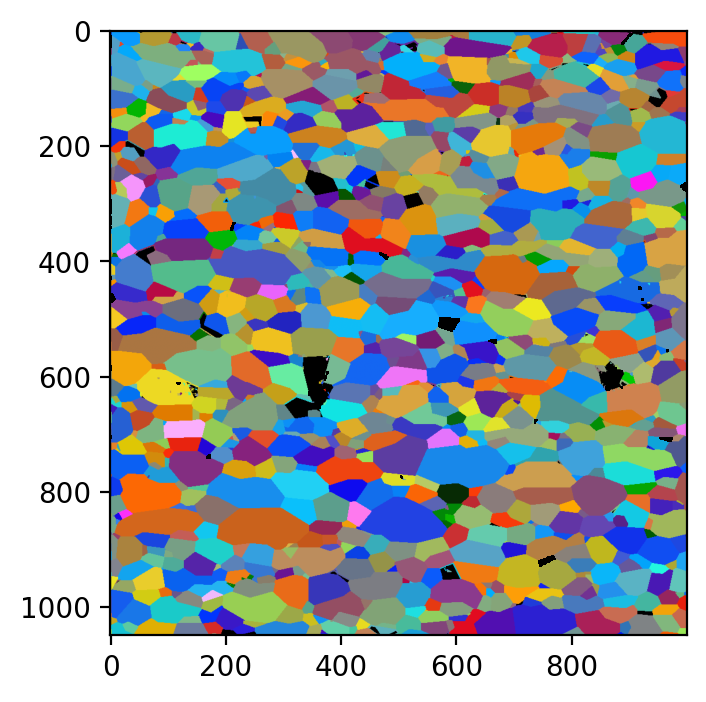

In [58]:
plt.imshow(flooded_grains)

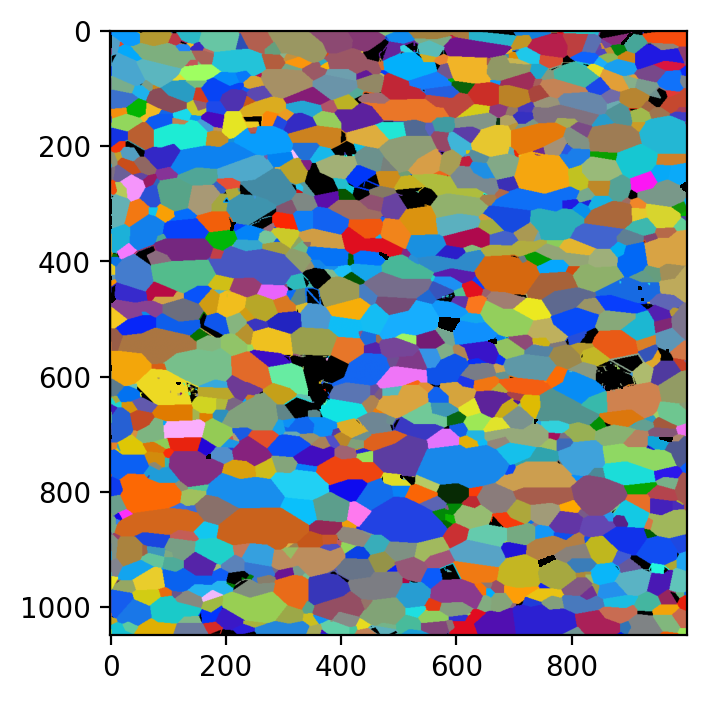

In [56]:
plt.imshow(flooded_grains)

In [40]:
np_img = np.zeros([height, width, 3])
np.sum(np_img==0)

3144000

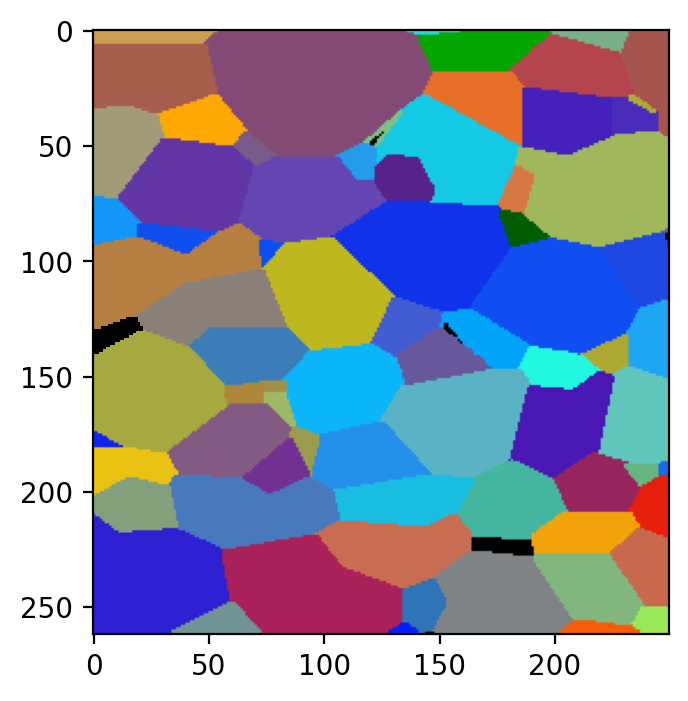

In [41]:
for tile in tiles:
#    centers, radii, vheight, image, drawing = fv.find_voids_2(tile)
    plt.imshow(tile)

In [34]:
df.iloc[2729]

right_phi1        0.253
right_PHI         0.293
right_phi2        6.111
left_phi1         5.032
left_PHI          0.650
left_phi2         1.972
ori_angle        57.110
right_ori_x      10.000
right_ori_y      18.000
right_ori_z     -21.000
left_ori_x       10.000
left_ori_y       18.000
left_ori_z      -21.000
length           11.015
trace_angle      63.000
x_start         697.000
y_start         766.140
x_end           702.000
y_end           756.330
grain_right    2409.000
grain_left     2403.000
Name: 2729, dtype: float64

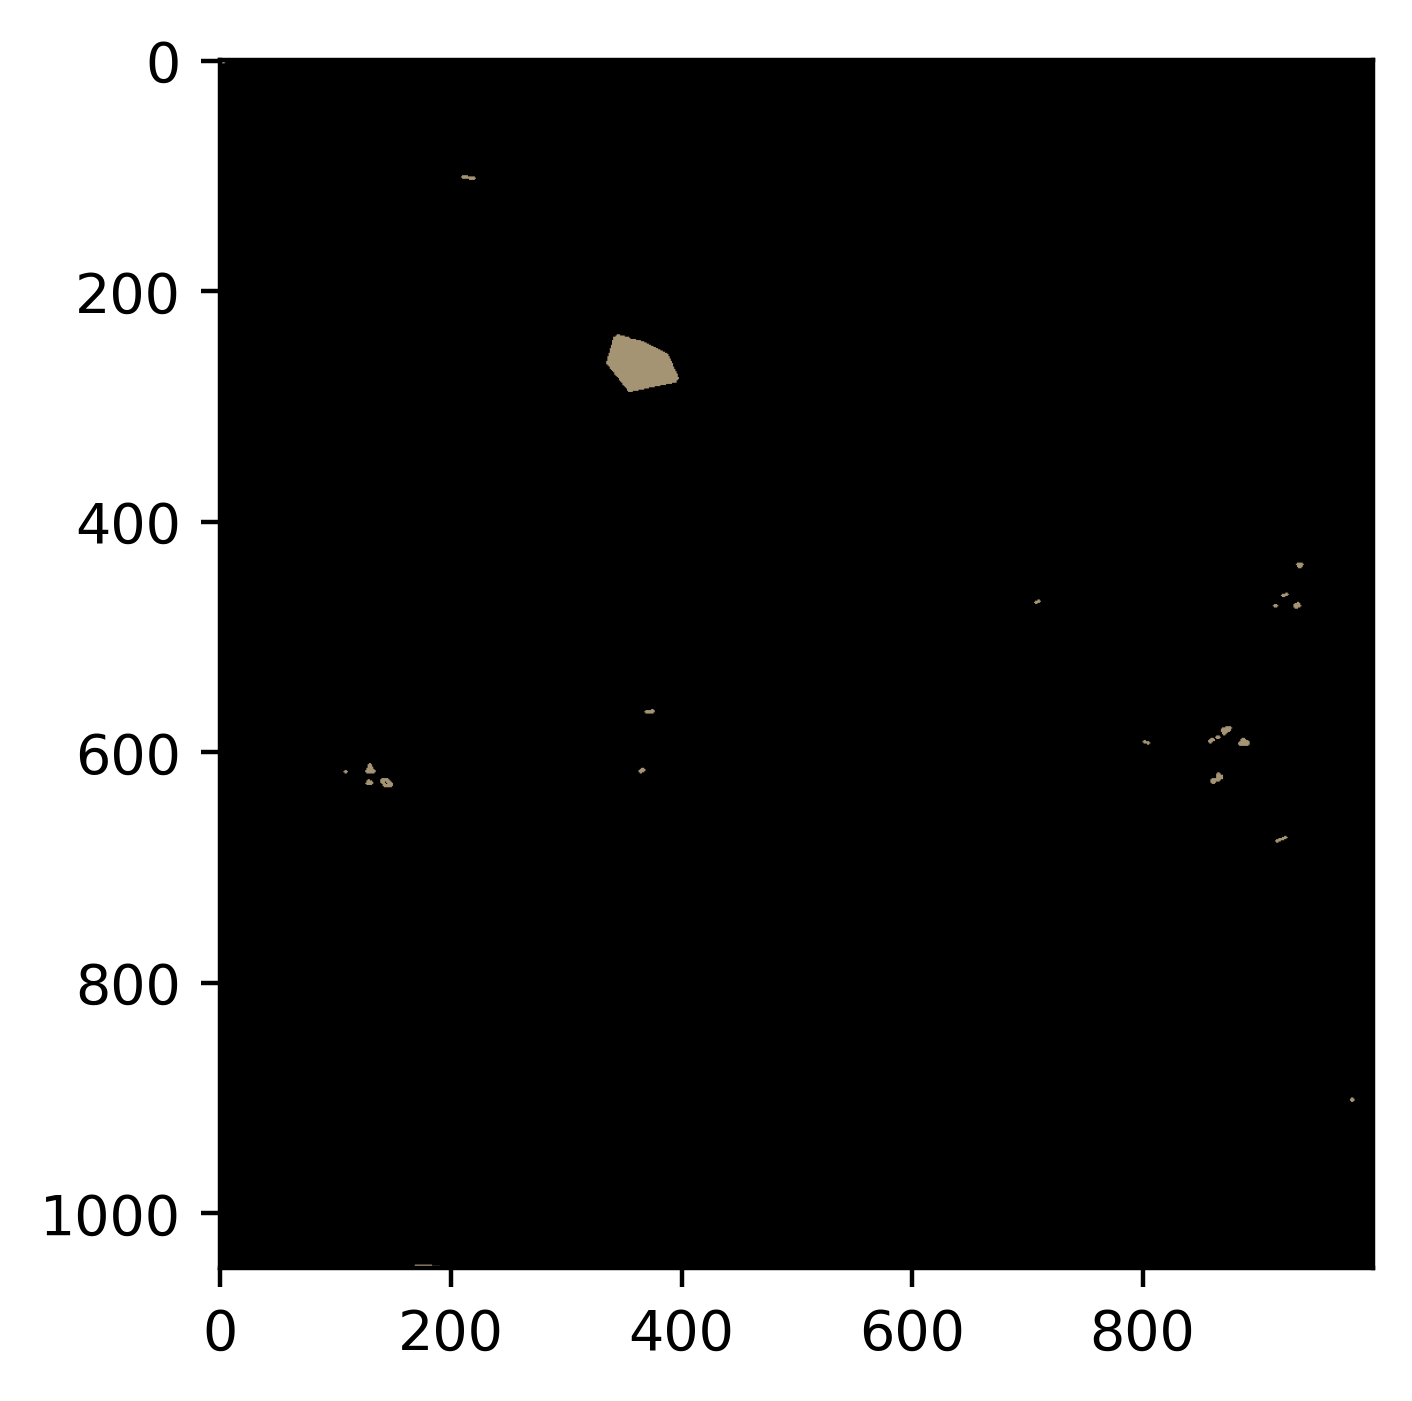

In [79]:
full_img = np.zeros([height, width, 3])

for grain in out:
#        grain = 1512
        One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
        grain_info = df_grains_norm.loc[grain,:]
        x_center = math.ceil(One_grain[['x_start','x_end']].mean().mean())
        y_center = math.ceil(One_grain[['y_start','y_end']].mean().mean())
#        One_grain = One_grain[One_grain["length"]>10]
    


        start = pd.DataFrame(columns=["x","y"])
        end = pd.DataFrame(columns=["x","y"])
        start[["x","y"]] = One_grain[['x_start','y_start']]
        end[["x","y"]] = One_grain[['x_end','y_end']]
        points = pd.concat([start,end])

        p = points.drop_duplicates()
        p1 = p.to_numpy()

        origin = [x_center,y_center]

        sort = sorted(p1, key=clockwiseangle_and_distance)
        a = []
        for b in sort:
            a.append(tuple((int(b[0]),int(b[1]))))

        cv2.polylines(np_img, np.array([a]), True, (phi1,Phi,phi2), 2)
        
        


        mask = flood(np_img, (y_center, x_center,0))
        if(np.sum(mask==1)<overflood):
#                np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
#                 cv2.imshow('f',flood_grains)
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()

            full_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
#         else:
#                 cv2.imshow('f',full_img[mask[:,:,1] !=0] = [phi1,Phi,phi2])
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()
            
        full_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
            
plt.imshow(full_img)

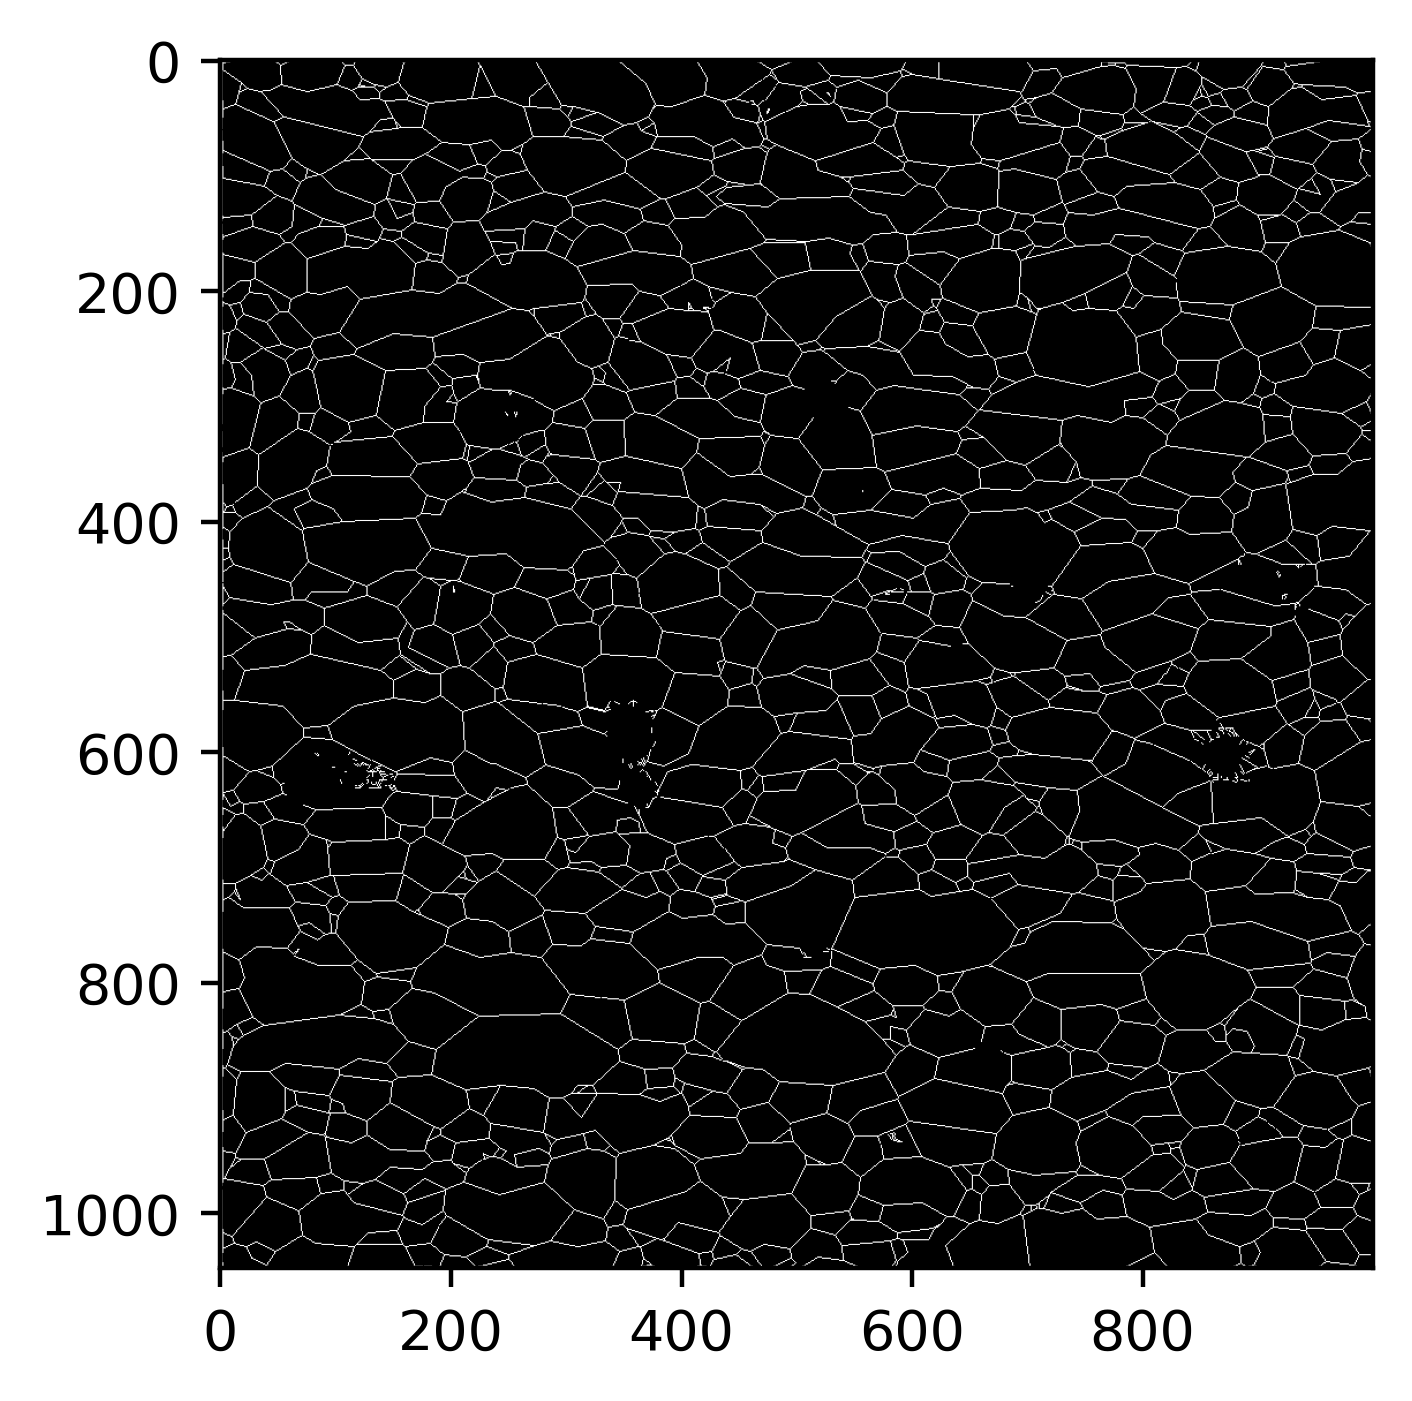

In [80]:

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

N = width//4
M = height//4

full_img = np.zeros([height, width, 3])

for idx, row in df.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))    
    rr,cc= draw.line(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    full_img[cc,rr,:3] = (1,1,1)

tiles = [full_img[x:x+M,y:y+N] for x in range(0,full_img.shape[0],M) for y in range(0,full_img.shape[1],N)]

plt.imshow(full_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


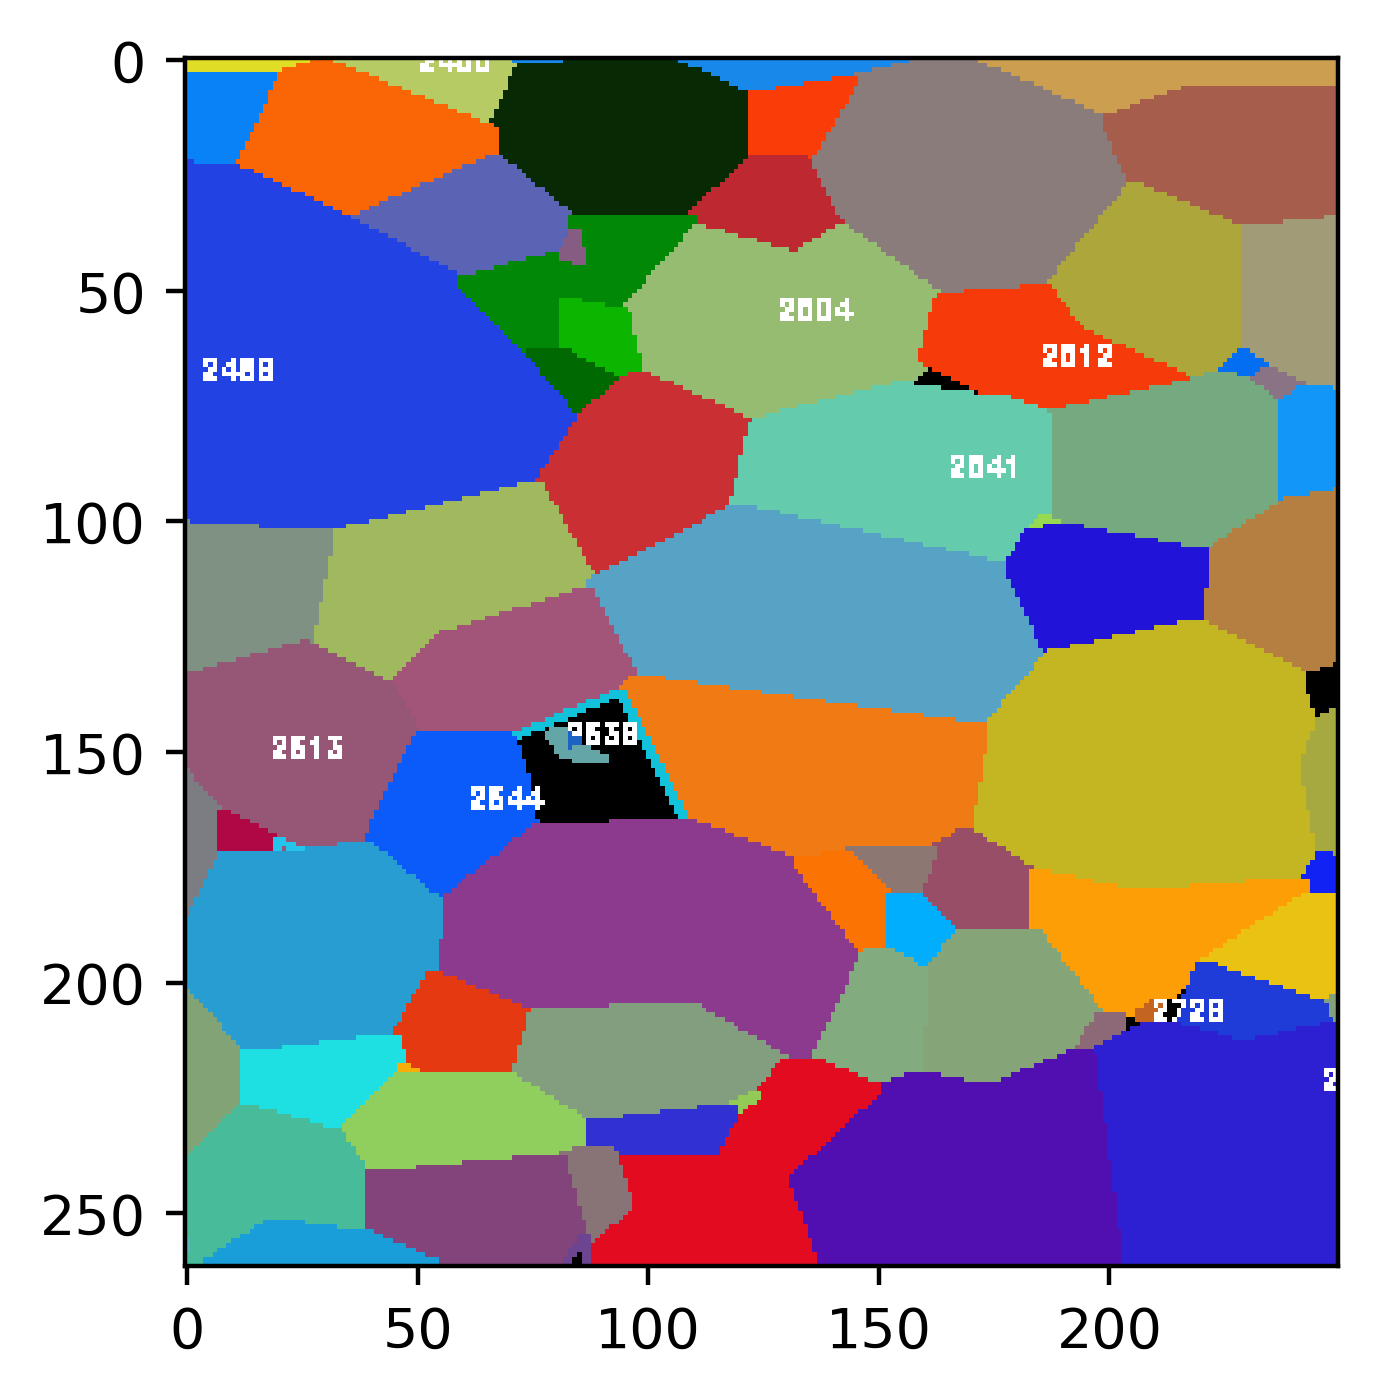

In [72]:
tiles = [flooded_grains[x:x+M,y:y+N] for x in range(0,flooded_grains.shape[0],M) for y in range(0,flooded_grains.shape[1],N)]
plt.imshow(tiles[14])

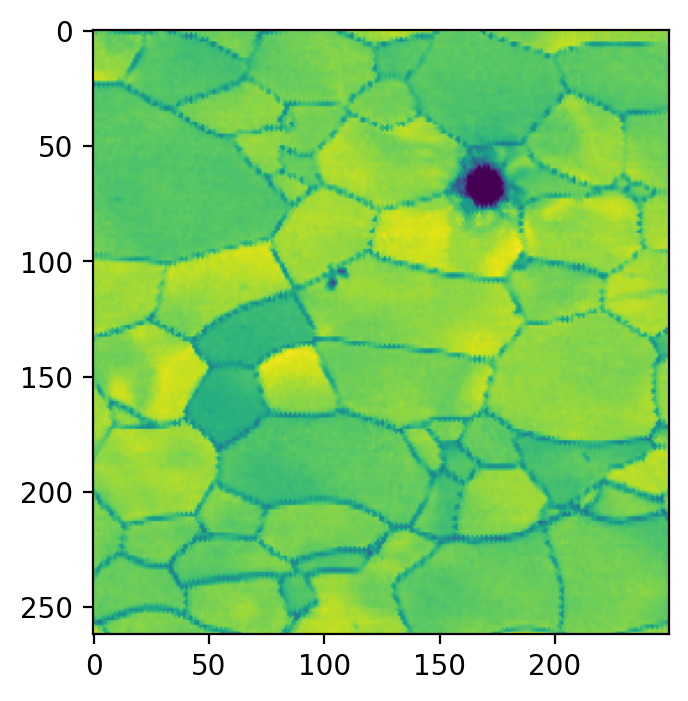

In [60]:
plt.imshow(tiles_grey[14])

In [10]:
len(tiles)

16

### Creating tiles from original image and detecting voids

In [76]:

grey_img = cv2.imread(path+ '.jpg', 0)
grey_img = cv2.resize(grey_img,(width,height),interpolation = cv2.INTER_AREA)

tiles_grey = [grey_img[x:x+M,y:y+N] for x in range(0,grey_img.shape[0],M) for y in range(0,grey_img.shape[1],N)]
i=0
for tile in tiles_grey:
    print("tile: "+str(i))
    i+=1
    centers, radii, vheight, image, drawing = fv.find_voids_2(tile)
    #plt.imshow(tile)

tile: 0
The program has detected 0 voids
tile: 1
The program has detected 0 voids
tile: 2
The program has detected 0 voids
tile: 3
The program has detected 0 voids
tile: 4
The program has detected 0 voids
tile: 5
The program has detected 0 voids
tile: 6
The program has detected 4 voids
tile: 7
The program has detected 1 voids
tile: 8
The program has detected 1 voids
tile: 9
The program has detected 1 voids
tile: 10
The program has detected 1 voids
tile: 11
The program has detected 1 voids
tile: 12
The program has detected 0 voids
tile: 13
The program has detected 0 voids
tile: 14
The program has detected 1 voids
tile: 15
The program has detected 0 voids
